In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import sqlite3

In [2]:
def update_species_latin_to_lowercase_and_replace(sql_doc):
    # Connect to the SQLite database
    conn = sqlite3.connect(sql_doc)
    cursor = conn.cursor()
    
    # Define a function to update species_latin column to lowercase and replace "unbekannt" with "unknown"
    def update_table(table_name):
        # Update species_latin column to lowercase
        cursor.execute(f"""
            UPDATE {table_name}
            SET species_latin = LOWER(species_latin)
        """)
        
        # Replace "unbekannt" with "unknown"
        cursor.execute(f"""
            UPDATE {table_name}
            SET species_latin = 'unknown'
            WHERE species_latin = 'unbekannt'
        """)
        
        conn.commit()
        print(f"Updated {table_name}: species_latin to lowercase and replaced 'unbekannt' with 'unknown'.")
    
    # Update both tables
    try:
        update_table('baumkataster')
        update_table('klimabaeume')
    except Exception as e:
        print(f"An error occurred: {e}")
    
    # Verify the updates
    def verify_update(table_name):
        cursor.execute(f"SELECT DISTINCT species_latin FROM {table_name} LIMIT 10")
        results = cursor.fetchall()
        print(f"Sample data from {table_name}:")
        for row in results:
            print(row)
    
    verify_update('baumkataster')
    verify_update('klimabaeume')
    
    # Close the connection
    conn.close()

if __name__ == "__main__":
    sql_doc = "../data/data.db"
    update_species_latin_to_lowercase_and_replace(sql_doc)


Updated baumkataster: species_latin to lowercase and replaced 'unbekannt' with 'unknown'.
Updated klimabaeume: species_latin to lowercase and replaced 'unbekannt' with 'unknown'.
Sample data from baumkataster:
('aesculus hippocastanum',)
('acer platanoides',)
('pinus nigra austriaca',)
('fraxinus excelsior',)
('tilia euchlora',)
('salix spec.',)
('carpinus betulus',)
('tilia cordata',)
('acer campestre',)
('malus lohrer rambur',)
Sample data from klimabaeume:
('tilia cordata greenspire',)
('ulmus new horizon',)
('acer platanoides',)
('sophora japonica',)
('fraxinus angustifolia raywood',)
('tilia vulgaris pallida',)
('robinia pseudoacacia',)
('unknown',)
('tilia tomentosa brabant',)
('ulmus rebona',)


In [3]:
# Set seaborn style for the plots
sns.set(style="whitegrid")

In [4]:
# Connect to the SQLite database
conn = sqlite3.connect('../data/data.db')

# Load the Baumkataster and Klimabaeume data
baumkataster_df = pd.read_sql_query("SELECT * FROM baumkataster", conn)
klimabaeume_df = pd.read_sql_query("SELECT * FROM klimabaeume", conn)

# Close the connection
conn.close()

### Distribution of Tree Species

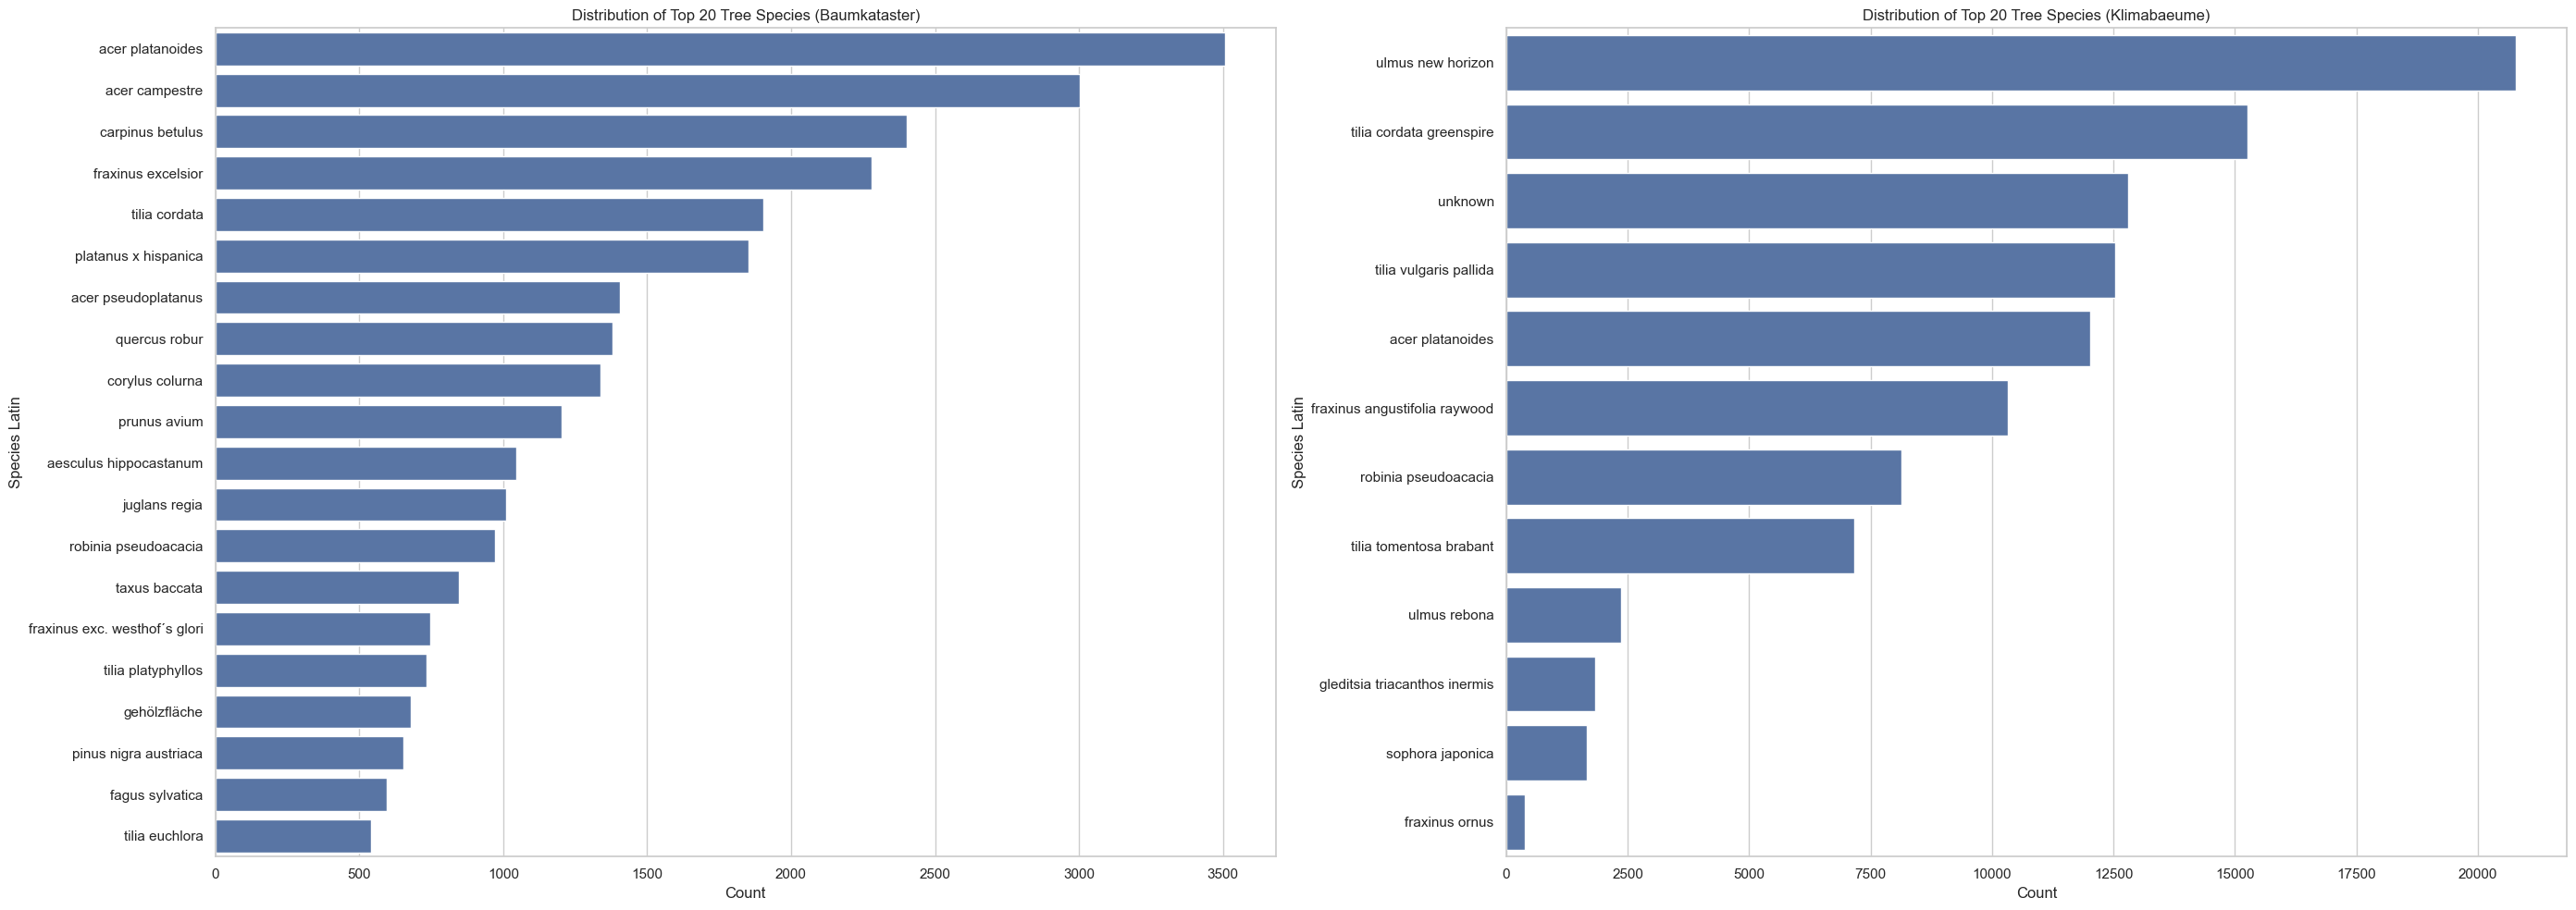

In [5]:
# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(28, 10))

# Plot for Baumkataster
top_species_baumkataster = baumkataster_df['species_latin'].value_counts().nlargest(20).index
filtered_baumkataster_df = baumkataster_df[baumkataster_df['species_latin'].isin(top_species_baumkataster)]
sns.countplot(y='species_latin', data=filtered_baumkataster_df, order=top_species_baumkataster, ax=axes[0])
axes[0].set_title('Distribution of Top 20 Tree Species (Baumkataster)')
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Species Latin')

# Plot for Klimabaeume
top_species_klimabaeume = klimabaeume_df['species_latin'].value_counts().nlargest(20).index
filtered_klimabaeume_df = klimabaeume_df[klimabaeume_df['species_latin'].isin(top_species_klimabaeume)]
sns.countplot(y='species_latin', data=filtered_klimabaeume_df, order=top_species_klimabaeume, ax=axes[1])
axes[1].set_title('Distribution of Top 20 Tree Species (Klimabaeume)')
axes[1].set_xlabel('Count')
axes[1].set_ylabel('Species Latin')

plt.tight_layout()
plt.savefig('distribution_of_tree_species.png')
plt.show()


In [5]:
# Merge datasets on species_latin column
merged_df = pd.merge(baumkataster_df, klimabaeume_df, on='species_latin', how='inner', suffixes=('_baumkataster', '_klimabaeume'))

# Check if merged_df is empty
if merged_df.empty:
    print("Merged dataframe is empty. Check data merging process.")

# Display first few rows of merged dataframe
print(merged_df.head())


       species     species_latin  crown_width  height  trunk_circumference  \
0  Spitz-Ahorn  acer platanoides           14    18.0                185.0   
1  Spitz-Ahorn  acer platanoides           14    18.0                185.0   
2  Spitz-Ahorn  acer platanoides           14    18.0                185.0   
3  Spitz-Ahorn  acer platanoides           14    18.0                185.0   
4  Spitz-Ahorn  acer platanoides           14    18.0                185.0   

  tree_type tree_number species_german  latitude  longitude  ...  \
0  Laubbaum       58753    Spitz-Ahorn    49.782    9.95677  ...   
1  Laubbaum       58753    Spitz-Ahorn    49.782    9.95677  ...   
2  Laubbaum       58753    Spitz-Ahorn    49.782    9.95677  ...   
3  Laubbaum       58753    Spitz-Ahorn    49.782    9.95677  ...   
4  Laubbaum       58753    Spitz-Ahorn    49.782    9.95677  ...   

  vol_water_content_100  permittivity_30  permittivity_100  conductivity_30  \
0                  31.0            30.32   

### Tree Health and Growth Relationship

In [5]:
# Drop rows with missing values in relevant columns
merged_df.dropna(subset=['vol_water_content_30', 'vol_water_content_100', 'trunk_circumference', 'height', 'crown_width'], inplace=True)


In [6]:
# Calculate correlation matrix for vol_water_content_30
corr_matrix_vol30 = merged_df[['vol_water_content_30', 'trunk_circumference', 'height', 'crown_width']].corr()

# Calculate correlation matrix for vol_water_content_100
corr_matrix_vol100 = merged_df[['vol_water_content_100', 'trunk_circumference', 'height', 'crown_width']].corr()


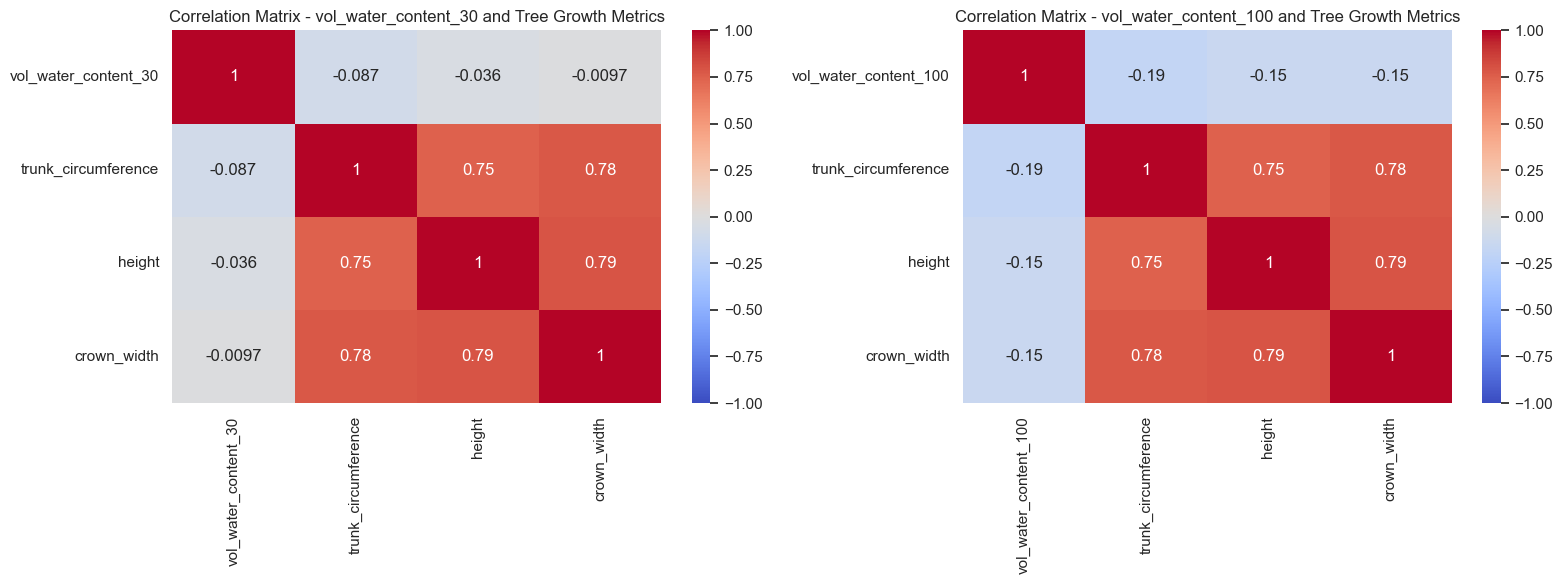

In [7]:
# Create figure and axes with subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot correlation matrix for vol_water_content_30
sns.heatmap(corr_matrix_vol30, annot=True, cmap='coolwarm', vmin=-1, vmax=1, ax=ax1)
ax1.set_title('Correlation Matrix - vol_water_content_30 and Tree Growth Metrics')

# Plot correlation matrix for vol_water_content_100
sns.heatmap(corr_matrix_vol100, annot=True, cmap='coolwarm', vmin=-1, vmax=1, ax=ax2)
ax2.set_title('Correlation Matrix - vol_water_content_100 and Tree Growth Metrics')

# Adjust layout
plt.tight_layout()
plt.savefig('corr_matrix_tree_health.png')
plt.show()

### Tree Characteristics Relationship

In [9]:
# Select relevant columns for soil composition and tree health
columns_of_interest = ['permittivity_30', 'permittivity_100', 
                       'conductivity_30', 'conductivity_100', 
                       'usable_field_capacity_30', 'usable_field_capacity_100', 
                       'temperature_30', 'temperature_100',
                       'trunk_circumference', 'height', 'crown_width']

# Convert selected columns to numeric if necessary
merged_df[columns_of_interest] = merged_df[columns_of_interest].apply(pd.to_numeric, errors='coerce')



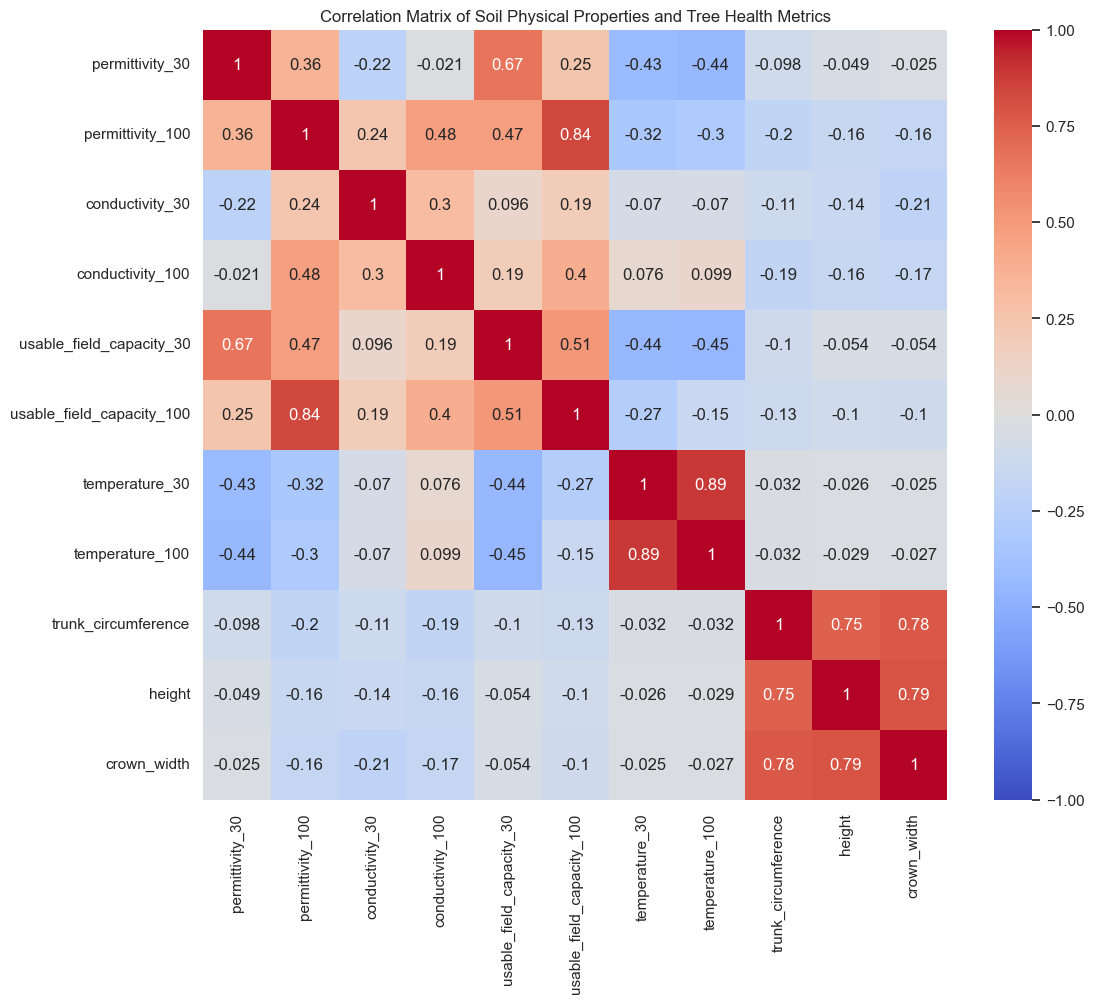

In [10]:
# Calculate correlation matrix
corr_matrix = merged_df[columns_of_interest].corr()

# Visualize correlation matrix as a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Soil Physical Properties and Tree Health Metrics')
plt.savefig('corr_matrix_tree_metrics.png')
plt.show()